In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.sac import SAC
from rl_hockey.common import utils

In [3]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

o_space = env.observation_space
ac_space = env.action_space

In [ ]:
max_episodes = 500
max_episode_steps = 500
updates_per_step = 1
warmup_transitions = 10000  # Number of transitions (not environment steps) to collect before training starts

In [5]:
agent = SAC(o_space.shape[0], action_dim=ac_space.shape[0], noise='pink', max_episode_steps=max_episode_steps)

In [6]:
critic_losses = []
actor_losses = []
rewards = []
steps = 0
gradient_steps = 0

In [7]:
run_name = 'hockey-shooting'

In [ ]:
pbar = tqdm(range(max_episodes), desc=run_name)
for i in pbar:    
    total_reward = 0
    state, _ = env.reset()

    agent.on_episode_start(i)

    for t in range(max_episode_steps):
        done = False
        action = agent.act(state.astype(np.float32))
        (next_state, reward, done, trunc, _) = env.step(action)
        agent.store_transition((state, action, reward, next_state, done))
        agent.store_transition((utils.mirror_state(state), utils.mirror_action(action), reward, utils.mirror_state(next_state), done))          
        state = next_state

        steps += 1
        total_reward += reward

        # Training starts after collecting warmup_transitions transitions
        # Since each environment step creates 2 transitions (regular + mirrored),
        # we need warmup_transitions / 2 environment steps
        if steps >= warmup_transitions / 2:
            stats = agent.train(updates_per_step)

            gradient_steps += updates_per_step
            critic_losses.extend(stats['critic_loss'])
            actor_losses.extend(stats['actor_loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)    
    
    pbar.set_postfix({
        'total_reward': total_reward,
        'episode_length': t,
    })

agent.save(f'../../../models/sac/{run_name}_{gradient_steps//1000}k.pt')

hockey-shooting: 100%|██████████| 500/500 [06:57<00:00,  1.20it/s, total_reward=-8.4, episode_length=80]  


In [9]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        window_start = max(0, i - window_size + 1)
        window = data[window_start:i + 1]
        moving_averages.append(sum(window) / len(window))
    
    return moving_averages

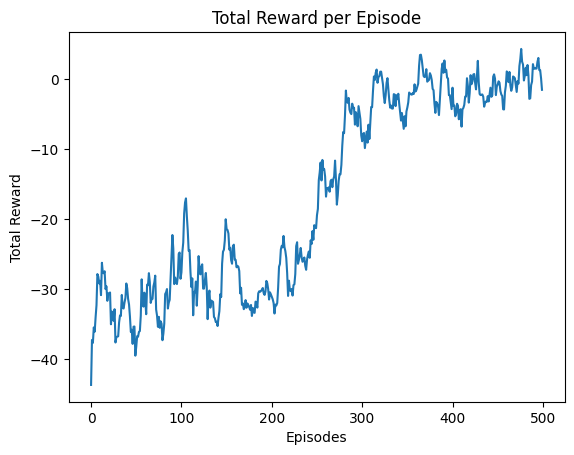

In [10]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

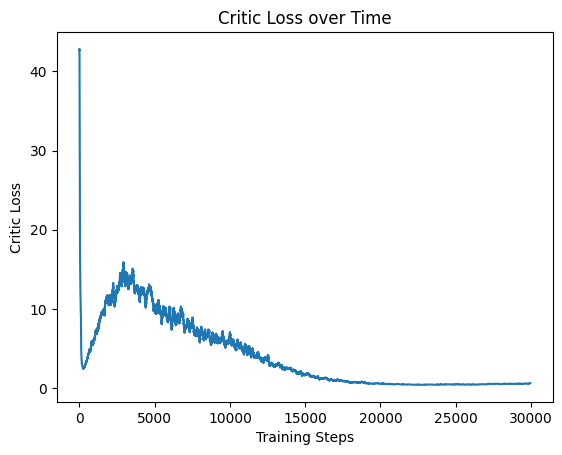

In [11]:
plt.plot(moving_average(critic_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Critic Loss')
plt.title('Critic Loss over Time')
plt.show()

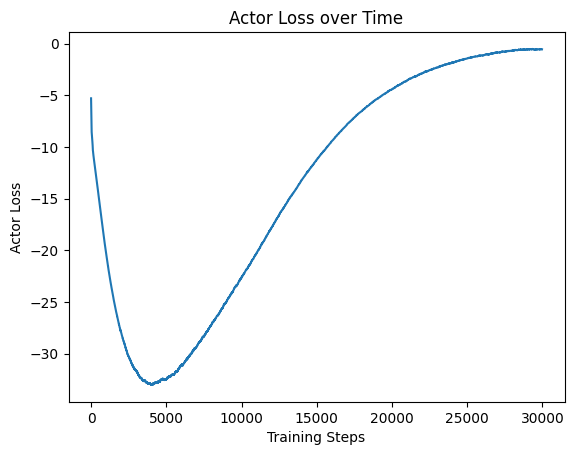

In [12]:
plt.plot(moving_average(actor_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Actor Loss')
plt.title('Actor Loss over Time')
plt.show()

In [13]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

In [14]:
total_reward = 0
state, _ = env.reset()
for t in range(max_episode_steps):
    env.render(mode="human")

    done = False
    action = agent.act(state.astype(np.float32), deterministic=True)
    (next_state, reward, done, trunc, _) = env.step(action)
    state = next_state

    total_reward += reward

    if done or trunc:
        break

print(f'total_reward: {total_reward}')

/home/nab/anaconda3/envs/rl-hockey/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA

total_reward: 8.399817291052738


In [15]:
env.close()